In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import string
import pickle

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Read in Data

In [139]:
fields = ['title', 'text', 'subject', 'date']

In [140]:
true_df = pd.read_csv("True_train.csv")

In [141]:
fake_df = pd.read_csv("Fake_train.csv", usecols=fields)

In [142]:
true_df.shape

(21498, 4)

In [143]:
fake_df.shape

(23511, 4)

In [145]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


# Pre-Process

#### Merge True and Fake

In [146]:
# add label
true_df["label"] = 1
fake_df["label"] = 0 

In [147]:
df = pd.concat([true_df, fake_df])

In [148]:
df.shape

(45009, 5)

#### Shuffle data

In [149]:
df = shuffle(df).reset_index(drop=True)

#### Check for missing values

In [150]:
df.isna().sum()

title       0
text        0
subject    21
date       21
label       0
dtype: int64

#### Remove rows with NaN

In [154]:
df=df.dropna()

In [155]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

#### merge columns 

In [156]:
# input = title + text + subject
df['data'] = df['title'] + " " + df['text'] + " " + df['subject']

In [157]:
# remove other columns
del df['title']
del df['text']
del df['subject']
del df['date']

In [158]:
df.head()

,label,data
0,0,COMMUNIST SYMPATHIZER NYC MAYOR DEBLASIO Encou...
1,0,ONLY HOURS AFTER DEATH Of Supreme Court Justic...
2,1,"Willing to oppose Trump, some Senate Republica..."
3,1,"After U.N. veto, Russia moves against chemical..."
4,1,Marseille attacker probably radicalized by bro...


#### Remove stop words & punctuation

In [159]:
# make all lower case
df['data'] = df['data'].str.lower()

In [160]:
# all stop words
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [161]:
# tokenize each article
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['data']), axis=1)

In [162]:
# remove stop words
cleaned_col = []

for row in df['tokenized_sents']:
    new_sent = []
    for word in row:
        if word not in stop_words:
            new_sent.append(word)
    
    cleaned_col.append(new_sent)
    
df['no_stop'] = cleaned_col

#### Remove stems

In [163]:
ps = PorterStemmer()

In [164]:
df["no_stem_no_stop"] = df["no_stop"].apply(lambda row: [ps.stem(w) for w in row])

In [165]:
del df['no_stop']
del df['tokenized_sents']

In [166]:
df["clean_text"] = df["no_stem_no_stop"].apply(lambda row: ' '.join(row))

In [167]:
del df["data"]

# Visualize

#### Final dataframe

In [168]:
df.head()

,label,no_stem_no_stop,clean_text
0,0,"[communist, sympath, nyc, mayor, deblasio, enc...",communist sympath nyc mayor deblasio encourag ...
1,0,"[hour, death, suprem, court, justic, scalia, d...",hour death suprem court justic scalia democrat...
2,1,"[will, oppos, trump, senat, republican, gain, ...",will oppos trump senat republican gain leverag...
3,1,"[u.n., veto, russia, move, chemic, weapon, wat...",u.n. veto russia move chemic weapon watchdog h...
4,1,"[marseil, attack, probabl, radic, brother, pol...",marseil attack probabl radic brother polic rom...


#### Most common words

In [169]:
wordcloud = WordCloud(width=1600, height = 800,
                     background_color = 'black',
                     min_font_size=10).generate(' '.join(df['clean_text']))

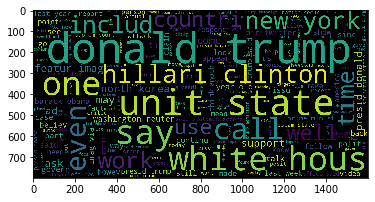

In [170]:
plt.imshow(wordcloud)

# Save Prepped Data to CSV 

In [171]:
df.to_csv("fake_news_with_covid.csv")

# Load Prepped Data

In [257]:
df = pd.read_csv("fake_news_with_covid.csv")

# Build Model

### Logistic Regression

In [258]:
# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.label, test_size=0.2, random_state=10)

In [259]:
# build the ml pipeline
pipeline = Pipeline([('vect', CountVectorizer()), # creates token counts
                     ('tfidf', TfidfTransformer()), # counts frequencies
                     ('model', LogisticRegression())]) # algorithm

In [260]:
# fit model
clf = pipeline.fit(X_train, y_train)

In [261]:
# get predictions on test
y_pred = clf.predict(X_test)

In [262]:
# performance metrics
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

In [263]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f_measure = 2 * ((precision*recall)/(precision+recall))

In [264]:
print("Precision: %.4f\nRecall: %.4f\nF-Measure: %.4f" % (precision,
                                                         recall,
                                                         f_measure))

Precision: 0.9907
Recall: 0.9928
F-Measure: 0.9918


In [267]:
# save classifier
f = open("log_clf", "wb")
p = pickle.Pickler(f)
p.dump(clf)
f.close()

### Random Forest 

In [268]:
# build the ml pipeline
pipeline = Pipeline([('vect', CountVectorizer()), # creates token counts
                     ('tfidf', TfidfTransformer()), # counts frequencies
                     ('model', RandomForestClassifier())]) # algorithm

In [269]:
# fit model
clf = pipeline.fit(X_train, y_train)

In [270]:
# get predictions on test
y_pred = clf.predict(X_test)

In [271]:
# performance metrics
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

In [272]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f_measure = 2 * ((precision*recall)/(precision+recall))

In [273]:
print("Precision: %.4f\nRecall: %.4f\nF-Measure: %.4f" % (precision,
                                                         recall,
                                                         f_measure))

Precision: 0.9967
Recall: 0.9949
F-Measure: 0.9958


In [274]:
# save classifier
f = open("randFor_clf", "wb")
p = pickle.Pickler(f)
p.dump(clf)
f.close()

## Prepare a New Test Set

In [227]:
fields = ['title', 'text', 'subject', 'date']

In [228]:
true_test = pd.read_csv("True_test.csv", usecols=fields)

In [229]:
fake_test = pd.read_csv("Fake_test.csv", usecols=fields)

In [230]:
true_test.shape

(91, 4)

In [231]:
fake_test.shape

(9, 4)

# Pre-Process

#### Merge True and Fake

In [232]:
# add label
true_test["label"] = 1
fake_test["label"] = 0 

In [233]:
df = pd.concat([true_test, fake_test])

In [234]:
df.shape

(100, 5)

#### Shuffle data

In [235]:
df = shuffle(df).reset_index(drop=True)

#### Check for missing values

In [236]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

#### merge columns 

In [237]:
# input = title + text + subject
df['data'] = df['title'] + " " + df['text'] + " " + df['subject']

In [238]:
# remove other columns
del df['title']
del df['text']
del df['subject']
del df['date']

In [239]:
df.head()

,label,data
0,1,Valencia criticises Atalanta coach who attende...
1,1,Germany is seeking a fresh $112 billion corona...
2,1,AstraZeneca is aiming to produce 2 billion dos...
3,1,Coronavirus News: Queens priest holding funera...
4,1,Hong Kong reports first local COVID-19 cases i...


#### Remove stop words & punctuation

In [240]:
# make all lower case
df['data'] = df['data'].str.lower()

In [241]:
# all stop words
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [242]:
# tokenize each article
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['data']), axis=1)

In [243]:
# remove stop words
cleaned_col = []

for row in df['tokenized_sents']:
    new_sent = []
    for word in row:
        if word not in stop_words:
            new_sent.append(word)
    
    cleaned_col.append(new_sent)
    
df['no_stop'] = cleaned_col

#### Remove stems

In [244]:
ps = PorterStemmer()

In [245]:
df["no_stem_no_stop"] = df["no_stop"].apply(lambda row: [ps.stem(w) for w in row])

In [246]:
del df['no_stop']
del df['tokenized_sents']

In [247]:
df["clean_text"] = df["no_stem_no_stop"].apply(lambda row: ' '.join(row))

In [248]:
del df["data"]

# Save Prepped Data to CSV 

In [249]:
df.to_csv("test_prepped.csv")

# Load Prepped Data 

In [2]:
df = pd.read_csv("test_prepped.csv")

## Evaluate

In [3]:
X_test = df.clean_text

In [4]:
y_test = df.label

#### Demo

In [25]:
X_test[0]

'valencia criticis atalanta coach attend match covid-19 spanish footbal club valencia criticis coach italian team atalanta “ put health numer peopl risk ’ ’ confess symptom covid-19 prior champion leagu match two side march interview italian newspap la gazzetta dello sport gian piero gasperini admit sick day second leg match valencia 10 march took place behind close door afraid go hospit overflow covid-19 patient time atalanta base bergamo one citi itali hardest hit covid-19 first leg champion leagu match two club 19 februari milan thought among main factor contribut escal case itali ’ worst-affect provinc describ “ biolog bomb ” turn north countri centr countri ’ outbreak day 40,000 footbal fan bergamo travel 30 mile 50km milan ’ san siro stadium watch atalanta beat valencia 4-1 “ afraid ” gaperini said “ day match valencia ’ well afternoon match felt even wors follow two night match ’ sleep much ’ fever felt miser fever 40 degre ambul went everi two minut hospit nearbi war night thou

In [22]:
X_test[1]

"germani seek fresh 112 billion coronaviru stimulu packag day eu launch histor 826 billion plan germani reportedli plan fresh domest stimulu packag worth much 100 billion euro 112 billion fight econom impact coronaviru day eu publish histor 750 billion euro 826 billion rescu plan bloomberg report german chancellor angela merkel host meet 8:00 a.m. et parti christian democrat union social democrat help form germani 's coalit govern discuss bailout one sourc told bloomberg tri negoti deal rang addit 50 billion euro 55.6 billion 100 billion euro 112 billion second time merkel 's govern launch stimulu done march coronaviru spread differ measur consid debt relief struggl region germani aid famili child cash bonus incent stimul car sale german financ minist olaf scholz consid extend programm call `` kurzarbeit '' state-regul workshar unemploy insur accord local newspap bild confidenti sourc said social democrat favour spend closer 112 billion merkel 's parti prefer keep new stimulu limit bil

In [12]:
y_test[0]

1

In [16]:
y_test[1]

1

In [9]:
# load logistic regression clf
f = open("log_clf", "rb")
u = pickle.Unpickler(f)
clf_log = u.load()
f.close()

In [30]:
y_pred = clf_log.predict(X_test[0:2])

In [31]:
print(y_pred)

[1 1]


#### Logistic regression

In [5]:
# load logistic regression clf
f = open("log_clf", "rb")
u = pickle.Unpickler(f)
clf_log = u.load()
f.close()

In [14]:
# get predictions on test
y_pred = clf_log.predict(X_test)

In [7]:
# performance metrics
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

In [8]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f_measure = 2 * ((precision*recall)/(precision+recall))

In [9]:
print("Precision: %.4f\nRecall: %.4f\nF-Measure: %.4f" % (precision,
                                                         recall,
                                                         f_measure))

Precision: 0.9529
Recall: 0.8901
F-Measure: 0.9205


<Figure size 432x288 with 0 Axes>

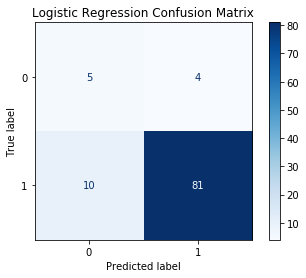

In [36]:
# plot confusion matrix
fig = plt.figure()
disp = plot_confusion_matrix(clf_log, X_test, 
                            y_test, display_labels=[0,1],
                            cmap=plt.cm.Blues,
                            normalize=None)

disp.ax_.set_title("Logistic Regression Confusion Matrix")
plt.savefig("confusion_matrix_log.png")
plt.show()



#### Random Forest

In [26]:
# load rf clf
f = open("randFor_clf", "rb")
u = pickle.Unpickler(f)
clf_rf = u.load()
f.close()

In [27]:
# get predictions on test
y_pred = clf_rf.predict(X_test)

In [28]:
# performance metrics
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

In [29]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f_measure = 2 * ((precision*recall)/(precision+recall))

In [30]:
print("Precision: %.4f\nRecall: %.4f\nF-Measure: %.4f" % (precision,
                                                         recall,
                                                         f_measure))

Precision: 0.9524
Recall: 0.6593
F-Measure: 0.7792


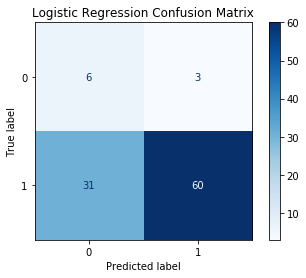

In [37]:
# plot confusion matrix
disp = plot_confusion_matrix(clf_rf, X_test, 
                            y_test, display_labels=[0,1],
                            cmap=plt.cm.Blues,
                            normalize=None)

disp.ax_.set_title("Logistic Regression Confusion Matrix")
plt.savefig("confusion_matrix_rf.png")
plt.show()

